
# 💤📚 Sleep–Study Trade-off Frontier with Personalized Recommendations


# Introduction

This notebook analyzes how students’ **study hours**, **sleep duration**, **attendance**, and **past academic scores** jointly influence their **final exam performance**.  
Using a dataset of 200 students, we develop a predictive model and explore trade-offs between study and sleep.  

The analysis proceeds as follows:
1. **Model Training**: Fit a regression model on study/sleep/attendance/past scores to predict exam results.  
2. **Sleep–Study Frontier**: Visualize the trade-off frontier to show combinations of study and sleep that maximize predicted performance.  
3. **Attendance-based Recommendations**: Provide differentiated suggestions depending on students’ attendance brackets (low/medium/high).  
4. **Individual Coaching Cards**: Generate personalized hour targets and “+1h sleep vs +1h study” scenarios for every student.  
5. **Sensitivity Checks**: Examine alternative daily caps (13h, 14h, 15h) and test the effect of enforcing a minimum sleep threshold (≥6h).  
6. **Tracking Changes**: Demonstrate how to re-run the analysis after a term to evaluate whether recommendations improved outcomes.  

This framework goes beyond pure prediction: it turns data into **actionable coaching guidance** for both educators and learners.


In [10]:

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from sklearn.model_selection import train_test_split
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.metrics import r2_score, mean_absolute_error

from itertools import product

# Display options
pd.set_option("display.max_columns", 100)
pd.set_option("display.width", 120)

# IMPORTANT (per platform requirements): 
# 1) Use matplotlib only (no seaborn), 2) one chart per figure, 3) do not set specific colors.


## 1) Load & Inspect Data

In [11]:
# Path for Kaggle: adjust if your dataset path differs.
CSV_PATH = "/kaggle/input/analyzing-student-academic-trends/student_exam_scores.csv"

# Fallback to local (for non-Kaggle execution)

    # Notice the forward slashes
df = pd.read_csv("C:/Users/HACKER/Downloads/Study-analysis/sleep-study-trade-off/student_exam_scores.csv")


df.head()

,student_id,hours_studied,sleep_hours,attendance_percent,previous_scores,exam_score
0,S001,8.0,8.8,72.1,45,30.2
1,S002,1.3,8.6,60.7,55,25.0
2,S003,4.0,8.2,73.7,86,35.8
3,S004,3.5,4.8,95.1,66,34.0
4,S005,9.1,6.4,89.8,71,40.3


## 2) Column Mapping (robust to naming)

In [12]:

df.columns = [c.strip().lower().replace(" ", "_") for c in df.columns]

possible = {
    "study": ["study", "study_hours", "study_hrs", "hours_study", "hours_of_study", "hours_studied"],
    "sleep": ["sleep", "sleep_hours", "sleep_hrs", "hours_sleep", "hours_of_sleep", "sleep_duration"],
    "attendance": ["attendance", "attendance_rate", "attend", "attendance_percent", "attendance_%"],
    "past": ["past_score", "previous_score", "prior_score", "baseline_score", "prev_score", "previous_scores"],
    "exam": ["exam_score", "final_score", "final_exam", "score", "exam"],
}

mapping = {}
for key, options in possible.items():
    for opt in options:
        if opt in df.columns:
            mapping[key] = opt
            break

required = ["study", "sleep", "attendance", "past", "exam"]
missing = [k for k in required if k not in mapping]
if missing:
    raise ValueError(f"Missing required fields in CSV: {missing}. Columns = {list(df.columns)}")

study_col = mapping["study"]
sleep_col = mapping["sleep"]
att_col   = mapping["attendance"]
past_col  = mapping["past"]
exam_col  = mapping["exam"]

data = df[[study_col, sleep_col, att_col, past_col, exam_col]].copy()

# Normalize attendance to 0-1 if it's in 0-100
if data[att_col].max() > 1.5:
    data[att_col] = data[att_col] / 100.0

data.describe().T


,count,mean,std,min,25%,50%,75%,max
hours_studied,200.0,6.3255,3.227317,1.000,3.500,6.1500,9.00000,12.0
sleep_hours,200.0,6.6220,1.497138,4.000,5.300,6.7000,8.02500,9.0
attendance_percent,200.0,0.7483,0.142499,0.503,0.622,0.7525,0.87425,1.0
previous_scores,200.0,66.8000,15.663869,40.000,54.000,67.5000,80.00000,95.0
exam_score,200.0,33.9550,6.789548,17.100,29.500,34.0500,38.75000,51.3


## 3) Train Predictive Model (Gradient Boosting)

In [13]:

X = data[[study_col, sleep_col, att_col, past_col]].values
y = data[exam_col].values

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.25, random_state=42)
model = GradientBoostingRegressor(random_state=42)
model.fit(X_train, y_train)

y_pred = model.predict(X_test)
r2 = r2_score(y_test, y_pred)
mae = mean_absolute_error(y_test, y_pred)

print(f"R2 on holdout: {r2:.3f}")
print(f"MAE on holdout: {mae:.3f}")


R2 on holdout: 0.797
MAE on holdout: 2.867


## 4) Sleep–Study Heatmap (under daily cap) & Frontier Overlay

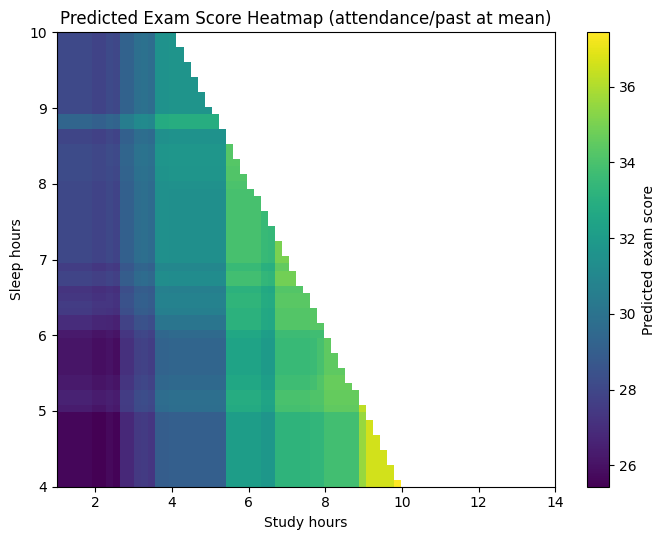

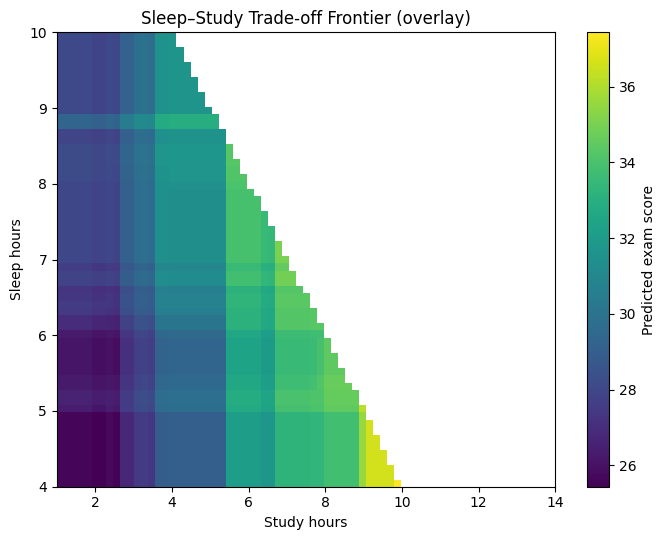

In [14]:

# Grid parameters & cap
cap_total = 14.0
att_ref = float(data[att_col].mean())
past_ref = float(data[past_col].mean())

sleep_grid = np.linspace(max(3, data[sleep_col].min()), min(12, data[sleep_col].max()+1), 61)
study_grid = np.linspace(max(0, data[study_col].min()), min(14, data[study_col].max()+2), 71)

Z = np.full((len(sleep_grid), len(study_grid)), np.nan)
for i, sl in enumerate(sleep_grid):
    for j, st in enumerate(study_grid):
        if sl + st <= cap_total:
            Xg = np.array([[st, sl, att_ref, past_ref]])
            Z[i, j] = model.predict(Xg)[0]

# Heatmap
plt.figure(figsize=(7,5.5))
extent = [study_grid.min(), study_grid.max(), sleep_grid.min(), sleep_grid.max()]
plt.imshow(Z, origin='lower', extent=extent, aspect='auto')
plt.colorbar(label="Predicted exam score")
plt.xlabel("Study hours")
plt.ylabel("Sleep hours")
plt.title("Predicted Exam Score Heatmap (attendance/past at mean)")
plt.tight_layout()
plt.show()

# Build frontier (best per sleep, then monotone filter)
candidates = []
for sl in np.linspace(sleep_grid.min(), sleep_grid.max(), 121):
    for st in np.linspace(study_grid.min(), study_grid.max(), 121):
        if sl + st <= cap_total and st >= 0 and sl >= 0:
            pred = model.predict(np.array([[st, sl, att_ref, past_ref]]))[0]
            candidates.append((sl, st, pred))
cand = pd.DataFrame(candidates, columns=["sleep","study","pred"])

best_by_sleep = cand.sort_values(["sleep","pred"], ascending=[True, False]).groupby("sleep", as_index=False).first()
best_by_sleep = best_by_sleep.sort_values("sleep").reset_index(drop=True)

frontier = []
current_best = -np.inf
for _, row in best_by_sleep.iterrows():
    if row["pred"] > current_best + 1e-9:
        frontier.append(row)
        current_best = row["pred"]
frontier = pd.DataFrame(frontier)

# Frontier overlay
plt.figure(figsize=(7,5.5))
plt.imshow(Z, origin='lower', extent=extent, aspect='auto')
if not frontier.empty:
    plt.plot(frontier["study"], frontier["sleep"], linewidth=2)
plt.colorbar(label="Predicted exam score")
plt.xlabel("Study hours")
plt.ylabel("Sleep hours")
plt.title("Sleep–Study Trade-off Frontier (overlay)")
plt.tight_layout()
plt.show()


## 5) Recommendations by Attendance Bracket

In [15]:

q1, q2 = data[att_col].quantile([0.33, 0.66])
def bracket(a):
    if a <= q1: return "Low"
    if a <= q2: return "Medium"
    return "High"

data["_att_bracket"] = data[att_col].apply(bracket)

def best_combo(att_ref, past_ref, cap=14.0):
    best = None
    best_pred = -np.inf
    for sl in np.linspace(max(3, data[sleep_col].min()), min(12, data[sleep_col].max()+1), 181):
        for st in np.linspace(max(0, data[study_col].min()), min(14, data[study_col].max()+2), 181):
            if sl + st <= cap and st >= 0 and sl >= 0:
                pred = model.predict(np.array([[st, sl, att_ref, past_ref]]))[0]
                if pred > best_pred:
                    best_pred = pred
                    best = (sl, st, pred)
    return best  # (sleep, study, pred)

recs = []
for br, g in data.groupby("_att_bracket"):
    att_ref = float(g[att_col].mean())
    past_ref = float(g[past_col].mean())
    sl, st, pred = best_combo(att_ref, past_ref, cap_total)
    recs.append({
        "Attendance bracket": br,
        "Ref. attendance (mean)": round(att_ref, 3),
        "Ref. past score (mean)": round(past_ref, 2),
        "Recommended sleep (h)": round(sl, 2),
        "Recommended study (h)": round(st, 2),
        "Predicted exam score": round(float(pred), 2)
    })

rec_df = pd.DataFrame(recs).sort_values("Attendance bracket")
rec_df


,Attendance bracket,Ref. attendance (mean),Ref. past score (mean),Recommended sleep (h),Recommended study (h),Predicted exam score
0,High,0.908,66.63,4.0,9.96,39.80
1,Low,0.581,65.98,4.0,9.96,37.34
2,Medium,0.752,67.79,4.0,9.96,37.43


## 6) Personalized Recommendations per Student

In [16]:

# Helper: enforce cap for +1h scenarios
def add_hour_with_cap(sleep, study, add_to="sleep", cap=14.0):
    sl, st = sleep, study
    if add_to == "sleep":
        new_sl, new_st = sl + 1.0, st
        if new_sl + new_st > cap:
            # reduce the other variable if possible
            deficit = (new_sl + new_st) - cap
            new_st = max(0.0, new_st - deficit)
        return new_sl, new_st
    else:
        new_sl, new_st = sl, st + 1.0
        if new_sl + new_st > cap:
            deficit = (new_sl + new_st) - cap
            new_sl = max(0.0, new_sl - deficit)
        return new_sl, new_st

def predict_score(study, sleep, att, past):
    Xg = np.array([[study, sleep, att, past]])
    return float(model.predict(Xg)[0])

def best_combo_for_student(att, past, cap=14.0):
    best = None
    best_pred = -np.inf
    for sl in np.linspace(max(3, data[sleep_col].min()), min(12, data[sleep_col].max()+1), 181):
        for st in np.linspace(max(0, data[study_col].min()), min(14, data[study_col].max()+2), 181):
            if sl + st <= cap and st >= 0 and sl >= 0:
                pred = predict_score(st, sl, att, past)
                if pred > best_pred:
                    best_pred = pred
                    best = (sl, st, pred)
    return best

# Build per-student table
rows = []
for idx, row in data.reset_index(drop=True).iterrows():
    sl0 = float(row[sleep_col]); st0 = float(row[study_col])
    att0 = float(row[att_col]);   past0 = float(row[past_col])
    cur_pred = predict_score(st0, sl0, att0, past0)

    # Optimal (sleep, study) under cap given this student's att/past
    sl_opt, st_opt, pred_opt = best_combo_for_student(att0, past0, cap_total)

    # +1h sleep vs +1h study uplift (cap-aware, local move)
    sl_s1, st_s1 = add_hour_with_cap(sl0, st0, add_to="sleep", cap=cap_total)
    sl_t1, st_t1 = add_hour_with_cap(sl0, st0, add_to="study", cap=cap_total)

    pred_sleep_plus1 = predict_score(st_s1, sl_s1, att0, past0)
    pred_study_plus1 = predict_score(st_t1, sl_t1, att0, past0)

    uplift_sleep = pred_sleep_plus1 - cur_pred
    uplift_study = pred_study_plus1 - cur_pred

    if uplift_sleep > uplift_study + 1e-9:
        next_best = "sleep+1h"
    elif uplift_study > uplift_sleep + 1e-9:
        next_best = "study+1h"
    else:
        next_best = "either (similar uplift)"

    rows.append({
        "student_id": idx + 1,
        "sleep_now": round(sl0,2),
        "study_now": round(st0,2),
        "attendance": round(att0,3),
        "past_score": round(past0,1),
        "pred_now": round(cur_pred,2),
        "opt_sleep": round(sl_opt,2),
        "opt_study": round(st_opt,2),
        "pred_opt": round(pred_opt,2),
        "delta_opt": round(pred_opt - cur_pred,2),
        "pred_if_sleep_plus1": round(pred_sleep_plus1,2),
        "pred_if_study_plus1": round(pred_study_plus1,2),
        "uplift_sleep_plus1": round(uplift_sleep,2),
        "uplift_study_plus1": round(uplift_study,2),
        "next_best_hour": next_best,
    })

personal_df = pd.DataFrame(rows)
personal_df.head(12)


,student_id,sleep_now,study_now,attendance,past_score,pred_now,opt_sleep,opt_study,pred_opt,delta_opt,pred_if_sleep_plus1,pred_if_study_plus1,uplift_sleep_plus1,uplift_study_plus1,next_best_hour
0,1,8.8,8.0,0.721,45.0,31.37,4.0,9.96,36.84,5.47,28.59,34.51,-2.78,3.13,study+1h
1,2,8.6,1.3,0.607,55.0,25.58,4.0,9.96,37.18,11.59,25.74,25.88,0.15,0.29,study+1h
2,3,8.2,4.0,0.737,86.0,35.75,4.0,9.81,43.07,7.32,35.99,35.75,0.24,0.00,sleep+1h
3,4,4.8,3.5,0.951,66.0,32.20,4.0,9.96,40.23,8.04,31.53,32.31,-0.66,0.11,study+1h
4,5,6.4,9.1,0.898,71.0,39.35,4.0,9.96,40.01,0.66,34.53,40.26,-4.82,0.91,study+1h
5,6,5.1,8.4,0.585,75.0,36.53,4.0,9.96,39.16,2.63,36.07,38.35,-0.46,1.82,study+1h
6,7,6.0,10.8,0.542,88.0,38.00,4.0,9.81,38.53,0.53,33.48,41.32,-4.53,3.32,study+1h
7,8,4.3,2.0,0.758,55.0,19.54,4.0,9.96,36.79,17.25,22.64,21.43,3.09,1.89,sleep+1h
8,9,5.9,5.6,0.816,84.0,35.66,4.0,9.81,42.28,6.62,37.33,35.22,1.67,-0.44,sleep+1h
9,10,8.9,1.3,0.668,70.0,29.81,4.0,9.96,37.79,7.98,28.54,29.86,-1.27,0.05,study+1h


In [17]:
def predict_score(study, sleep, att, past):
    Xg = np.array([[study, sleep, att, past]])
    return float(model.predict(Xg)[0])

def search_best(att, past, cap=14.0, min_sleep=None):
    """
    attendance / past score を入力に、cap 制約 & 最小睡眠制約を満たす最適 sleep, study を返す
    """
    sl_min = max(3.0, data[sleep_col].min())
    sl_max = min(12.0, data[sleep_col].max() + 1.0)
    st_min = max(0.0, data[study_col].min())
    st_max = min(14.0, data[study_col].max() + 2.0)

    if min_sleep is not None:
        sl_min = max(sl_min, min_sleep)

    best = None
    best_pred = -np.inf
    for sl in np.linspace(sl_min, sl_max, 181):
        for st in np.linspace(st_min, st_max, 181):
            if sl + st <= cap and st >= 0 and sl >= 0:
                pred = predict_score(st, sl, att, past)
                if pred > best_pred:
                    best_pred = pred
                    best = (sl, st, pred)
    return best

## 7) Sensitivity Checks

In [ ]:
print("\n=== Sensitivity Checks (caps=13/14/15, min sleep constraint optional) ===")
caps = [13.0, 14.0, 15.0]
summary_rows = []
for cap in caps:
    for min_sl in [None, 6.0]:
        bests = [search_best(float(r[att_col]), float(r[past_col]), cap=cap, min_sleep=min_sl) for _, r in data.iterrows()]
        preds = [b[2] for b in bests]
        sls   = [b[0] for b in bests]
        sts   = [b[1] for b in bests]
        summary_rows.append({
            "cap_hours": cap,
            "min_sleep": "≥6h" if min_sl is not None else "none",
            "avg_opt_pred": float(np.mean(preds)),
            "avg_opt_sleep": float(np.mean(sls)),
            "avg_opt_study": float(np.mean(sts)),
        })
sens_summary = pd.DataFrame(summary_rows)
display(sens_summary)

# 折れ線図（平均最適スコア vs cap）— 1図のみ、色指定なし
plt.figure(figsize=(6,4))
for label, g in sens_summary.groupby("min_sleep"):
    xs = g["cap_hours"].values
    ys = g["avg_opt_pred"].values
    plt.plot(xs, ys, marker="o", label=label)
plt.xlabel("Daily cap (hours)")
plt.ylabel("Average optimal predicted score")
plt.title("Sensitivity: Cap vs Avg Optimal Score")
plt.legend()
plt.tight_layout()
plt.show()


=== Sensitivity Checks (caps=13/14/15, min sleep constraint optional) ===


##  8) Tracking Changes (Template + Demo)

In [ ]:
# 実運用では、次学期の実測データを df_next に読み込み、同じマッピング→学習→評価で効果検証します。
# ここではデモとして「最適値に 60% 近づいた」ケースをシミュレートし、改善幅を推定します。

adoption_rate = 0.6  # 0..1（推奨にどの程度寄せられたか）

sim_rows = []
for i, r in data.reset_index(drop=True).iterrows():
    att0 = float(r[att_col]); past0 = float(r[past_col])
    sl0  = float(r[sleep_col]); st0 = float(r[study_col])
    cur_pred = predict_score(st0, sl0, att0, past0)

    sl_opt, st_opt, pred_opt = search_best(att0, past0, cap=14.0, min_sleep=None)

    # 最適へ部分的に移動
    sl_new = sl0 + adoption_rate * (sl_opt - sl0)
    st_new = st0 + adoption_rate * (st_opt - st0)

    # cap を超えたら射影で調整
    if sl_new + st_new > 14.0:
        scale = 14.0 / (sl_new + st_new)
        sl_new *= scale; st_new *= scale

    pred_new = predict_score(st_new, sl_new, att0, past0)

    sim_rows.append({
        "student_id": i+1,
        "sleep_now": sl0, "study_now": st0, "pred_now": cur_pred,
        "sleep_opt": sl_opt, "study_opt": st_opt, "pred_opt": pred_opt,
        "sleep_new": sl_new, "study_new": st_new, "pred_new": pred_new,
        "delta_new": pred_new - cur_pred,
        "delta_opt": pred_opt - cur_pred,
    })

tracking_demo = pd.DataFrame(sim_rows)

print("\n=== Tracking Demo (first 10 rows) ===")
display(tracking_demo.head(10))

print("\n=== Aggregate Improvement (Demo, adoption_rate=0.6) ===")
agg = tracking_demo.agg({
    "pred_now": "mean",
    "pred_new": "mean",
    "pred_opt": "mean",
    "delta_new": "mean",
    "delta_opt": "mean",
}).to_frame(name="mean").round(3)
display(agg)


# Conclusion

This notebook demonstrates how lifestyle and academic habits can be translated into **personalized and evidence-based guidance**:

- Sleep–Study Frontier shows the balance between sleep and study time, clarifying the most efficient allocation of limited hours.  
- Attendance-based recommendations highlight how habits interact with study and sleep, showing different optimal points for different student groups.  
- Individual coaching cards transform predictions into concrete advice, including hour targets and simple behavioral tips.  
- Sensitivity checks confirm that recommendations remain stable under different assumptions (daily caps, minimum sleep).  
- Tracking changes provides a template for longitudinal evaluation, ensuring that advice can be monitored and refined across terms.  

Overall, this approach connects predictive modeling with **practical decision-making**, enabling teachers and students to make informed adjustments that maximize academic performance while maintaining healthy sleep habits.



In [ ]:
import matplotlib.pyplot as plt
import seaborn as sns
plt.figure(figsize=(8, 6))
sns.histplot(data=data, x=study_col, bins=15, kde=True)
plt.title('Distribution of Study Hours')
plt.xlabel('Study Hours per Day')
plt.ylabel('Number of Students')
plt.show()

In [ ]:
plt.figure(figsize=(8, 6))
sns.scatterplot(data=data, x=study_col, y=final_exam_col)
plt.title('Study Hours vs. Final Exam Score')
plt.xlabel('Study Hours per Day')
plt.ylabel('Final Exam Score')
plt.grid(True)
plt.show()

In [ ]:
# First, create the attendance groups
data['attendance_group'] = pd.cut(data[att_col], 
                                  bins=3, 
                                  labels=['Low', 'Medium', 'High'])

# Now, create the bar plot
plt.figure(figsize=(8, 6))
sns.barplot(data=data, x='attendance_group', y=final_exam_col, ci=None)
plt.title('Average Final Exam Score by Attendance Group')
plt.xlabel('Attendance Group')
plt.ylabel('Average Final Exam Score')
plt.show()

In [ ]:
# Select only the numerical columns for the correlation matrix
numerical_cols = [study_col, sleep_col, att_col, past_col, final_exam_col]
corr_matrix = data[numerical_cols].corr()

# Create the heatmap
plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt='.2f')
plt.title('Correlation Matrix of Student Data')
plt.show()